In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.energies.alp_energy import ALPEnergy
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
n_particles = 22
n_spatial_dim = 3
dimensionality = n_spatial_dim * n_particles

energy = ALPEnergy(
    data_path="../../data/alanine/",
    pdb_filename="../../data/pdbs/A_capped.pdb",
    n_particles=n_particles,
    spatial_dim=n_spatial_dim,
    dimensionality=dimensionality,
    temperature=1200,
    device = device,
    device_index="0",
)
energy_low = ALPEnergy(
    data_path="../../data/alanine/",
    pdb_filename="../../data/pdbs/A_capped.pdb",
    n_particles=n_particles,
    spatial_dim=n_spatial_dim,
    dimensionality=dimensionality,
    temperature=300,
    device = device,
    device_index="0",
)

In [28]:
path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{1200}_100000.npz"
samples = np.load(path)
samples = samples["all_positions"]
samples = samples.reshape(-1, dimensionality)
high_temp_samples = energy.normalize(samples)
high_temp_samples = torch.tensor(high_temp_samples, device=device)

path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{300}_100000.npz"
samples = np.load(path)
samples = samples["all_positions"]
samples = samples.reshape(-1, dimensionality)
low_temp_samples = energy_low.normalize(samples)
low_temp_samples = torch.tensor(low_temp_samples, device=device)

In [21]:
high_temp_samples = torch.cat((energy.sample_train_set(10000), energy.sample_test_set(10000), energy.sample_val_set(10000)), dim=0)
low_temp_samples = torch.cat((energy_low.sample_train_set(10000), energy_low.sample_test_set(10000), energy_low.sample_val_set(10000)), dim=0)

Plotting Ramachandran 0 out of 1
Plotting Ramachandran 0 out of 1


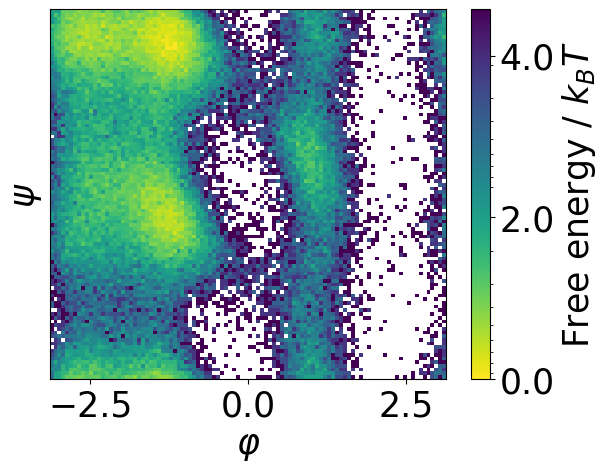

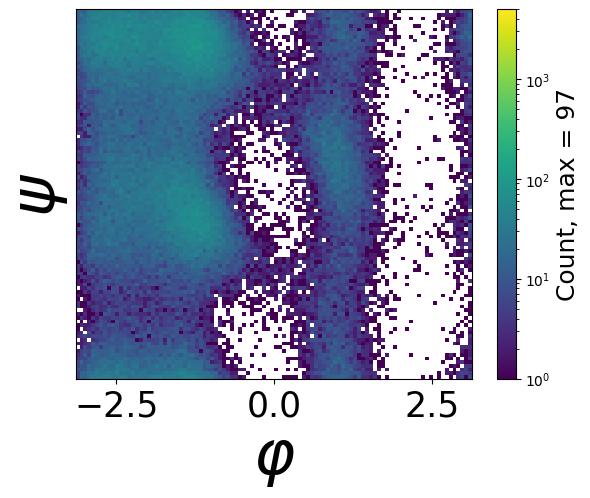

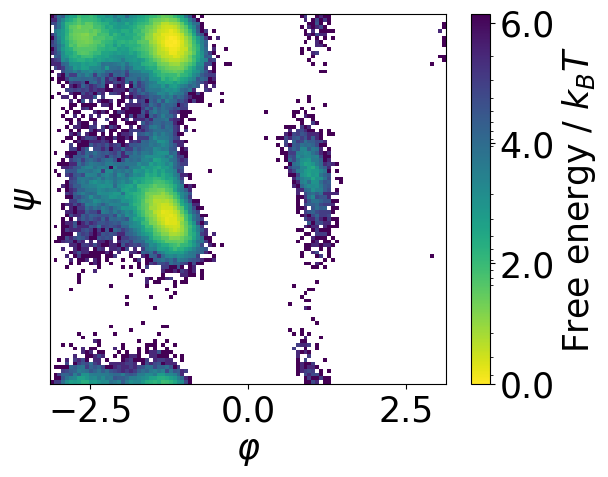

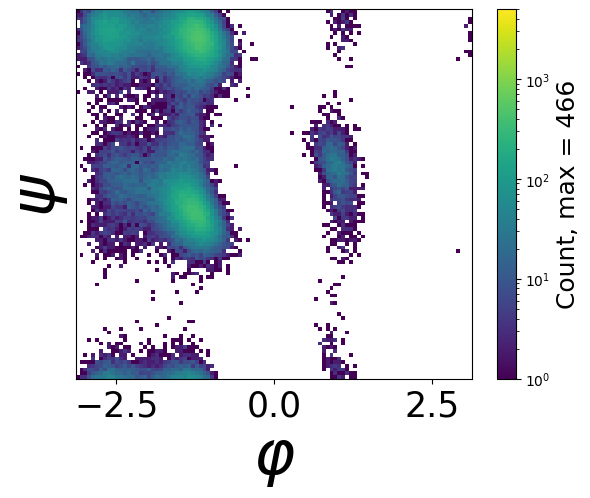

In [31]:
energy.plot_ramachandran(high_temp_samples.cpu());
energy_low.plot_ramachandran(low_temp_samples.cpu());

In [11]:
high_temp_std

tensor(0.1651, device='cuda:0')

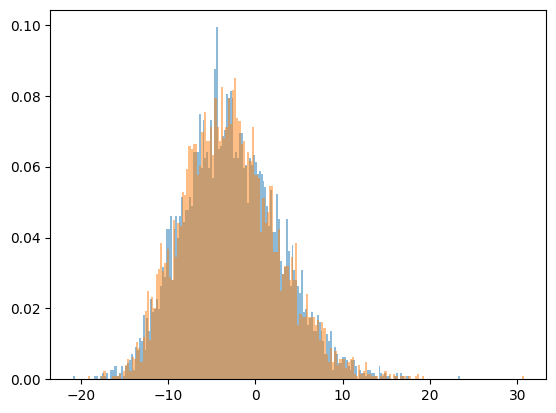

In [12]:
plt.hist(-energy(energy.sample_train_set(5000)).cpu(), bins=200, density=True, alpha=0.5);
plt.hist(-energy(energy.sample_test_set(5000)).cpu(), bins=200, density=True, alpha=0.5);

In [26]:
import numpy as np
import glob

from collections import defaultdict
T = 1
noise_std = 0.2

samples = defaultdict(list)


temps = [300,400,450,500,550,600,1200]
for temp in temps:
    print(temp)
    path = f"/network/scratch/a/alexander.tong/energy_temp/data/md/A_capped/A_capped_{temp}_100000.npz"

    try:
        samples = np.load(path)
        samples = samples["all_positions"]
        samples = samples.reshape(-1, dimensionality)
        print(f"Samples at {temp} has shape: {samples.shape}")
    except PermissionError:
        print(f"Permission error for file {path}")
        break

    idxs = np.random.permutation(samples.shape[0])
    train_idx = idxs[:10000]
    val_idx = idxs[10000: 20000]
    test_idx = idxs[20000: 30000]


    samples_train = samples[train_idx]
    samples_val = samples[val_idx]
    samples_test = samples[test_idx]

    # if directory does not exist, create it
    import os
    temp = temp.__float__()
    data_path = f"../../data/alanine/AL{n_particles}_temp_{temp}"
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    else:
        print(f"Directory {data_path} already exists. Overwriting data.")
    break
    #np.save(data_path + f"/train_split_AL{n_particles}-10000.npy", samples_train)
    #np.save(data_path + f"/val_split_AL{n_particles}-10000.npy", samples_val)
    #np.save(data_path + f"/test_split_AL{n_particles}-10000.npy", samples_test)
    print(f"Saved data for temperature {temp} to {data_path}")

300
Samples at 300 has shape: (100000, 66)
Saved data for temperature 300.0 to ../../data/alanine/AL22_temp_300.0
400
Samples at 400 has shape: (100000, 66)
Saved data for temperature 400.0 to ../../data/alanine/AL22_temp_400.0
450
Samples at 450 has shape: (100000, 66)
Saved data for temperature 450.0 to ../../data/alanine/AL22_temp_450.0
500
Samples at 500 has shape: (100000, 66)
Saved data for temperature 500.0 to ../../data/alanine/AL22_temp_500.0
550
Samples at 550 has shape: (100000, 66)
Saved data for temperature 550.0 to ../../data/alanine/AL22_temp_550.0
600
Samples at 600 has shape: (100000, 66)
Saved data for temperature 600.0 to ../../data/alanine/AL22_temp_600.0
1200
Samples at 1200 has shape: (100000, 66)
Saved data for temperature 1200.0 to ../../data/alanine/AL22_temp_1200.0
